In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Input, ReLU
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import optimizers, layers
from scipy import integrate

## Main driver functions

In [2]:
H = 1

In [3]:
def runif():
    return tf.random.uniform([1], dtype=tf.float64)[0]

def rexp():
    return -tf.math.log(runif())

@tf.function
def inverse(x, w, b, v):
  # Calculate v0
  w = tf.cast(w, dtype=tf.float64)
  b = tf.cast(b, dtype=tf.float64)
  v = tf.cast(v, dtype=tf.float64)
  v0 = -(tf.reshape(b,[1,H])@v)[0]
  # print(v0)
  x = tf.dtypes.cast(x, tf.float64)
  num_layer = w.shape[1]

  b_over_w = - b / w # the negative sign is important
  b_over_w = tf.reshape(b_over_w, [-1])# change it to row vector
  # Then we need to compute range for the inverse function
  r_x = tf.reshape(
      [tf.matmul( ( tf.nn.relu(w * b_over_w[i] + b) ), v) + v0 for i in range(1)], 
      [-1]
      )
  
  # pad r_x with 0 and inf
  # right side gives us the right index
  zero = tf.constant([0.], dtype=tf.float64)
  pos = tf.searchsorted(tf.sort(tf.concat([zero, r_x, [np.inf]],0)), x,side='right') # get the interval index
  # tf.print('pos',pos)
  pos = tf.reshape(pos,[]) # get only numerical value
  # change it to row vector
  v = tf.reshape(v, [-1])
  w = tf.reshape(w, [-1])
  
  index = tf.argsort(r_x)
  # sort according to the index
  v_b = tf.gather(v * b, index)
  v_w = tf.gather(v * w, index)

  num = x - v0 - tf.reduce_sum(v_b[:(pos - 1)])
  deo = tf.reduce_sum(v_w[:(pos - 1)])

  with tf.control_dependencies([
      tf.debugging.assert_positive(num, message='inverse num'),
      tf.debugging.assert_positive(deo, message='inverse deo'),
  ]):
    return tf.math.divide_no_nan(num, deo)[0]

@tf.function
def gen_gaps(w, b, v, k: int,  
             theta=tf.constant(1e-4, dtype=tf.float64), 
             rho=tf.constant(1e-5, dtype=tf.float64)) -> tf.Tensor:
    '''Return k gaps sampled from genetic distribution with rate function eta.'''
    w = tf.cast(w, dtype=tf.float64)
    b = tf.cast(b, dtype=tf.float64)
    v = tf.cast(v, dtype=tf.float64)
    v0 = -(tf.reshape(b,[1,H])@v)[0]
    # print(v0)
    z = tf.convert_to_tensor([[rexp()]])
    x = inverse(z, w, b, v)[0]  # initialize x by sampling from prior
    tf.debugging.assert_positive(x, message='gen_gaps first x')
    # print('first x passed')
    pos = tf.constant(0., dtype=tf.float64)
    j = 0
    ta = tf.TensorArray(tf.float64, size=k + 2)
    while tf.less(j, k + 2):
        # x' satisfies R(x') - R(u*x) = Z => x' = Rinv(Z + R(u*x))
        u = runif()
        z = rexp()
        u_x = tf.convert_to_tensor([[u * x]])
        r_u_x = v0 + tf.nn.relu(w * u_x + b) @ v # compute R(u_x)

        x = inverse((z + r_u_x), w, b, v)[0]  # segment height
        with tf.control_dependencies(
            [tf.debugging.assert_positive(x, message='gen_gaps second x')]
        ):
          pos += rexp() / (x * (theta + rho))  # length to next event
        while runif() < (theta / (theta + rho)) and tf.less(j, k + 2):
            ta = ta.write(j, pos)
            j += 1
            pos += rexp() / (x * (theta + rho))  # length to next event
    ret = ta.stack()[1:]  # first obs suffers from inspection paradox?
    diff = ret[1:] - ret[:-1]
    with tf.control_dependencies([
        tf.debugging.assert_positive(diff, message='gen_gaps diff')
    ]):
        return tf.cast(diff, tf.float64)

## Function for computing squared error

In [4]:
def relu(x):
  return np.maximum(0,x)
def SSE(x):
  weights = generator.get_weights()
  w = weights[0]
  b = weights[2]
  v = weights[1]
  v0 = 0
  r_hat = v0 + relu(w * x + b) @ v

  w = np.array([[1.]])
  b = np.array([0.])
  v = np.array([[1.]])
  v0 = np.array([0.])
  r = v0 + relu(w * x + b) @ v

  return np.power(r_hat.reshape(-1) - r.reshape(-1),2) * np.exp(-x)

## Generator


In [5]:
class CustomGenGaps(keras.layers.Layer):
  ''' Take one parameter H as input 
      Then construct one hidden layer with H units'''
  def __init__(self, H, name='gen_gaps_layer'):
      super(CustomGenGaps, self,).__init__(name=name)
      w_init = tf.random_normal_initializer(mean=1.5)
      # b_init = tf.random_normal_initializer(mean=0.)
      self.w = self.add_weight(shape=(1,H), initializer=w_init,dtype='float32',trainable=True, constraint=tf.keras.constraints.NonNeg())
      self.b = self.add_weight(shape=(H,), initializer='zeros',dtype='float32',trainable=False)
      self.v = self.add_weight(shape=(H,1), initializer=w_init,dtype='float32',trainable=True,constraint=tf.keras.constraints.NonNeg())
      # self.w = tf.Variable(initial_value=w_init(shape=(1,H), dtype='float64'), trainable=True)
      # self.b = tf.Variable(initial_value=tf.zeros((H,), dtype='float64'),trainable=False)
      # self.v = tf.Variable(initial_value=w_init(shape=(H,1), dtype='float64'), trainable=True)
      # self.v0 = tf.Variable(initial_value=b_init(shape=(1,), dtype='float64'), trainable=True)

  def call(self,length):
      return tf.reshape(gen_gaps(self.w,self.b,self.v,length),[1,length])

class Generator(keras.Model):
  ''' wrap the GenGaps layer into Keras Model '''
  def __init__(self, H):
    super(Generator, self).__init__()
    self.GenLayer = CustomGenGaps(H)

  def call(self, inputs, training=True):
    return self.GenLayer(inputs)

generator = Generator(1)
generator(10)

<tf.Tensor: shape=(1, 10), dtype=float64, numpy=
array([[ 6317.60593965, 51554.86541433,   133.35198076, 12365.23259925,
        17124.16476977,   818.94101876,  4748.48992939, 23126.76590514,
        25163.80684262, 10304.91408788]])>

Objective funtion

In [6]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gen_gaps_layer (CustomGenGap multiple                  3         
Total params: 3
Trainable params: 2
Non-trainable params: 1
_________________________________________________________________


In [7]:
# Since activation of last layer of discriminator is None, I set from_logits to be True
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def generator_objective(dx_of_gx):
    # Labels are true here because generator thinks he produces real images. 
    return cross_entropy(tf.ones_like(dx_of_gx), dx_of_gx)

## Comparison between real and fake *R( )*

The code below works fine on "Real R" 

Initial SSE: 2.2940568606438574


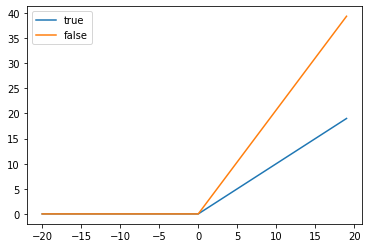

In [8]:
''' Below is the setting of real R '''
w = tf.Variable([[1.]], trainable=False, dtype=tf.float64)
b = tf.Variable([0.], trainable=False, dtype=tf.float64)
v = tf.Variable([[1.]], trainable=False, dtype=tf.float64)
v0 = tf.Variable([0.], trainable=False, dtype=tf.float64)

R = lambda x : (v0 + tf.nn.relu(w * np.array([[x]]) + b) @ v)[0]
# Real Generator Plot
x = np.array([np.array([[i]]) for i in range(-20,20)])
y = R(x)
plt.plot(x.reshape((-1,)),tf.reshape(y,[-1,]),label = 'true')
# Plot fake R
Weights = generator.trainable_weights
# Since b is zero, then v00 is zero as well
v00 = 0
y = np.array([v00 + tf.nn.relu(Weights[0] * i + 0) @ Weights[1] for i in x])
print('Initial SSE:',integrate.quad(SSE, 0, np.inf)[0])
plt.plot(x.reshape((-1,)),y.reshape((-1,)),label = 'false')
plt.legend()
plt.show()

## discriminator

In [9]:
discriminator = Sequential(
    [
     Input(shape=(10,)),
     Dense(10),
     LeakyReLU(0.2),
     Dense(10),
     LeakyReLU(0.2),
     Dense(10),
     LeakyReLU(0.2),
     Dense(1)
    ],
    name="discriminator",
)


objective function

In [10]:
def discriminator_objective(d_x, g_z, smoothing_factor = 0.8):
    """
    d_x = real output
    g_z = fake output
    """
    real_loss = cross_entropy(tf.ones_like(d_x) * smoothing_factor, d_x) # If we feed the discriminator with real images, we assume they all are the right pictures --> Because of that label == 1
    fake_loss = cross_entropy(tf.zeros_like(g_z), g_z) # Each noise we feed in are fakes image --> Because of that labels are 0
    total_loss = real_loss + fake_loss
    
    return total_loss

## Optimizer

In [11]:
generator_optimizer = tf.keras.optimizers.RMSprop(0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002)

## Define trining_step

In [12]:
@tf.function
def training_step(generator, discriminator, k):
    for _ in range(k):
         with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            g_z = tf.math.log(generator(10)) / 10
            d_x_true = discriminator(tf.math.log(tf.reshape(gen_gaps(w,b,v,10), (1,10))) / 10)
            d_x_fake = discriminator(g_z)

            discriminator_loss = discriminator_objective(d_x_true, d_x_fake)
            # d_loss.append(discriminator_loss)
            # Adjusting Gradient of Discriminator
            gradients_of_discriminator = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # Takes a list of gradient and variables pairs
              
            generator_loss = generator_objective(d_x_fake)
            # Adjusting Gradient of Generator
            gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
            # print(gradients_of_generator)
            # print(generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

In [13]:
def performance_check(generator, epoch):
  # Real Generator Plot
  x = np.array([np.array([[i]]) for i in range(-20,20)])
  y = R(x)
  plt.plot(x.reshape((-1,)),tf.reshape(y,[-1,]),label = 'true')
  # Plot fake R
  Weights = generator.trainable_weights
  # Since b is zero, then v00 is zero as well
  v00 = 0
  learned_R = lambda x : v00 + tf.nn.relu(Weights[0] * x + 0) @ Weights[1]
  y = learned_R(x)
  print('epoch:', epoch)
  print('SSE:', integrate.quad(SSE, 0, np.inf)[0])
  plt.plot(x.reshape((-1,)),tf.reshape(y,[-1,]),label = 'learned')
  plt.legend()
  plt.show()

In [14]:
def training(epoches):
  for epoch in range(epoches):
    training_step(generator, discriminator ,60)
    mse.append(integrate.quad(SSE, 0, np.inf)[0])
    if (epoch % 30) == 0: 
      performance_check(generator,epoch)
      # plt.plot(range(len(d_loss)),d_loss)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  after removing the cwd from sys.path.


epoch: 0
SSE: 2.2148617082520046


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  del sys.path[0]


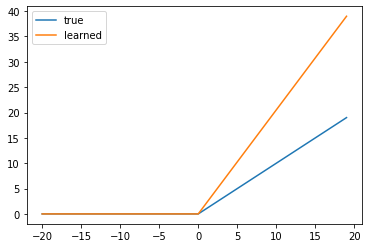

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  after removing the cwd from sys.path.


epoch: 30
SSE: 0.6452686760125886


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  del sys.path[0]


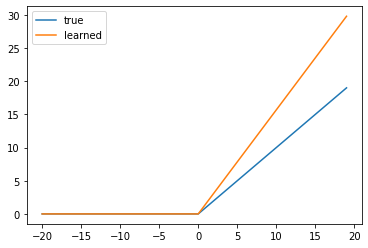

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  after removing the cwd from sys.path.


epoch: 60
SSE: 0.044765398348072


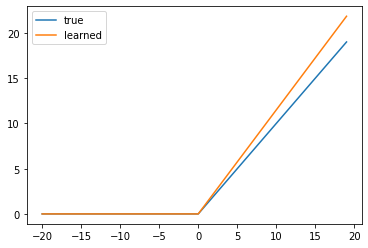

epoch: 90
SSE: 0.08260075120453325


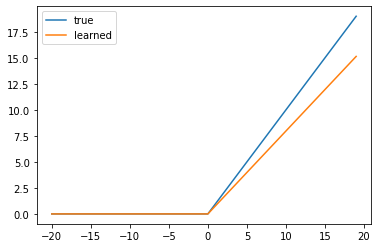

epoch: 120
SSE: 0.47819628562114075


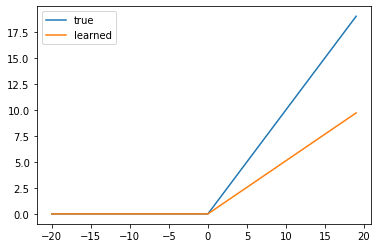

epoch: 150
SSE: 0.1135149863620871


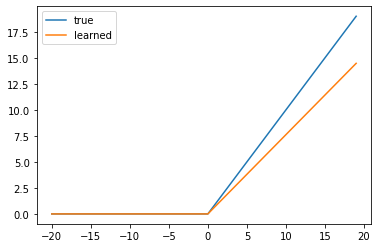

epoch: 180
SSE: 0.022494190051201575


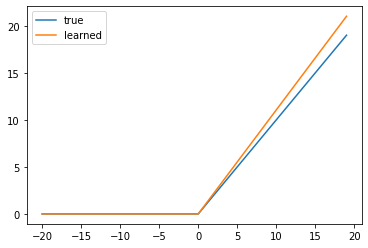

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  after removing the cwd from sys.path.


epoch: 210
SSE: 0.5205506942638513


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  del sys.path[0]


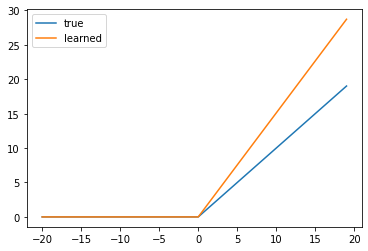

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  after removing the cwd from sys.path.


epoch: 240
SSE: 0.0677686179316568


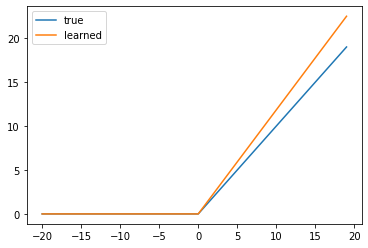

epoch: 270
SSE: 0.061378339146881906


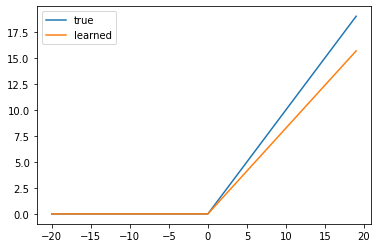

epoch: 300
SSE: 0.07470121958899398


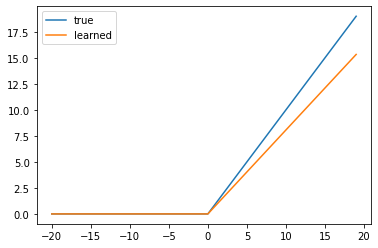

epoch: 330
SSE: 0.05211239047089866


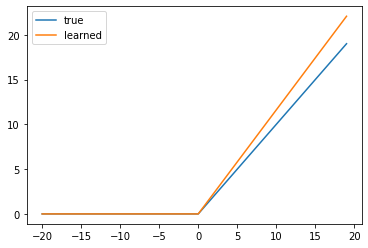

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  after removing the cwd from sys.path.


epoch: 360
SSE: 0.001979094534144393


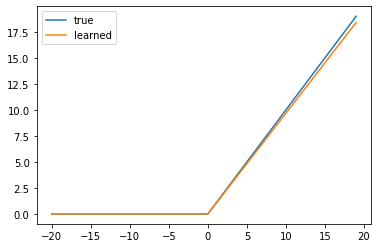

epoch: 390
SSE: 0.00040287166915715434


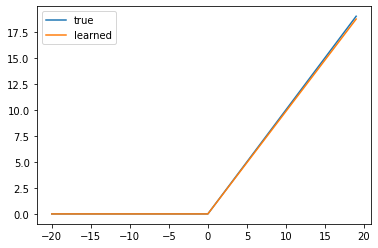

epoch: 420
SSE: 0.01633438697407405


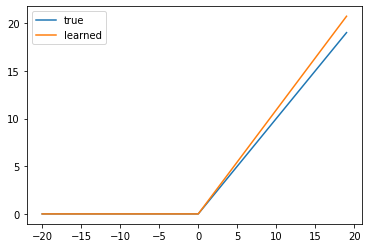

epoch: 450
SSE: 0.008088004822410878


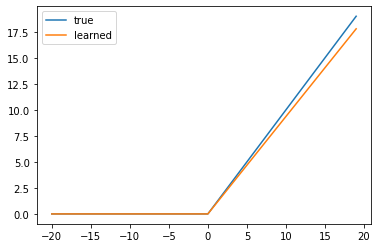

epoch: 480
SSE: 0.03313400585517078


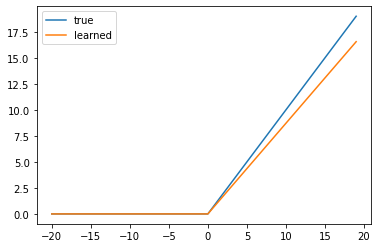

CPU times: user 6min 13s, sys: 12.3 s, total: 6min 25s
Wall time: 5min 20s


In [15]:
%%time
mse = []
EPOCHES = 500
training(EPOCHES)

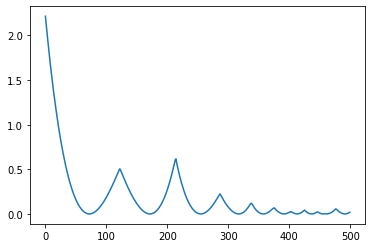

In [16]:
plt.plot(range(len(mse)),mse)